In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhocon import ConfigFactory

In [2]:
from modularprophet.containers import Model, Sequential, Ensemble
from modularprophet.compositions import Additive, Stationary
from modularprophet.components import Trend, Regressor
from modularprophet.modules.ar_net import LaggedNet
from modularprophet.forecaster import ModularProphet

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/air_passengers.csv")

In [4]:
config = ConfigFactory.parse_string(json.dumps({
    "training": {
        "optimizer": "bfgs", 
        "learning_rate": 0.1,
        "epochs": 15,
        "batch_size": 256,
        "optimization_metric": "loss"
    },
    "model": {
        "args": {
            "n_forecasts": 1,
            "n_lags": 5
        }
    }
}))

In [5]:
m = ModularProphet(
    Additive(
        Trend(),
        LaggedNet(n_lags=5)
    )
)
m

Model(
	Additive(
		(trend): Trend('time',)
		(laggednet): LaggedNet(5, 0, 0, 'lags')
	)
)

In [6]:
m.fit(df, config, n_forecasts=10)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/karl/git/idic/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type     | Params
-----------------------------------
0 | model | Additive | 52    
-----------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)
/Users/karl/git/idic/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoade

""


In [8]:
x, y, y_hat, components = m.predict(df)

/Users/karl/git/idic/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


### Convert Predictions to Readable Format

In [13]:
def array_to_df(name, array):
    df = pd.DataFrame(array)
    df.columns = [f"{name}_({c + 1})" for c in df.columns]
    return df

def long_to_staircase_df(df):
    n_shifts = ["".join(filter(str.isdigit, c)) for c in list(df.columns)]
    n_shifts = [int(c)-1 if c != "" else 0 for c in n_shifts]
    for i in range(max(n_shifts)):
        df = pd.concat([df, pd.Series(np.nan, dtype=np.float32)], axis=0, ignore_index=True)
    for col, shifts in zip(df.columns, n_shifts):
        df[col] = df[col].shift(shifts)
    df.drop([0], axis=1, inplace=True)
    return df

In [14]:
prediction_df = {name: array_to_df(name, c) for name, c in components.items()}
prediction_df = pd.concat(prediction_df.values(), axis=1)
staircase_df = long_to_staircase_df(prediction_df)
staircase_df

,Trend_(1),Trend_(2),Trend_(3),Trend_(4),Trend_(5),Trend_(6),Trend_(7),Trend_(8),Trend_(9),Trend_(10),...,y_hat_(1),y_hat_(2),y_hat_(3),y_hat_(4),y_hat_(5),y_hat_(6),y_hat_(7),y_hat_(8),y_hat_(9),y_hat_(10)
0,-1.275636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.498849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.256727,-1.256727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.420294,-1.468636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.237188,-1.237188,-1.237188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.285046,-1.343598,-1.424636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.217649,-1.217649,-1.217649,-1.217649,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.286211,-1.247769,-1.310097,-1.389739,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.198740,-1.198740,-1.198740,-1.198740,-1.19874,NaN,NaN,NaN,NaN,NaN,...,-1.416044,-1.285934,-1.225443,-1.319610,-1.406437,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,NaN,NaN,NaN,NaN,NaN,1.295326,1.295326,1.295326,1.295326,1.295326,...,NaN,NaN,NaN,NaN,NaN,1.552996,2.042336,2.468644,2.347416,2.621165
135,NaN,NaN,NaN,NaN,NaN,NaN,1.314865,1.314865,1.314865,1.314865,...,NaN,NaN,NaN,NaN,NaN,NaN,1.603045,1.868810,1.737105,1.734098
136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333773,1.333773,1.333773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.552802,1.247012,1.002848
137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.353312,1.353312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.384106,0.951930


In [25]:
y_df = pd.concat([pd.DataFrame(y[:,0], columns=["y"], dtype=np.float32), pd.DataFrame(y[-1][1:], columns=["y"])], axis=0, ignore_index=True)
x_df = pd.concat([pd.DataFrame(x[:,0], columns=["x"], dtype=np.float32), pd.DataFrame(x[-1][1:], columns=["x"])], axis=0, ignore_index=True)

staircase_df = pd.concat([
    staircase_df,
    y_df,
    x_df,
], axis=1)

<Axes: xlabel='x'>

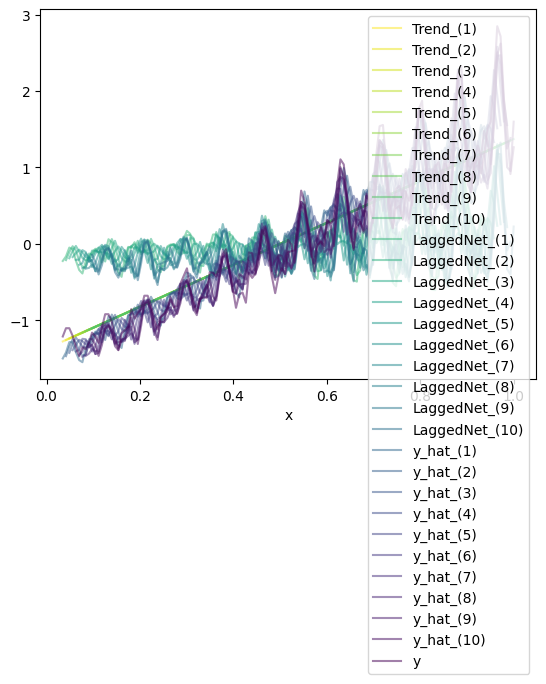

In [46]:
staircase_df.plot(x="x", colormap="viridis_r")

### Evaluate Average Error per Forecast Step

<Axes: >

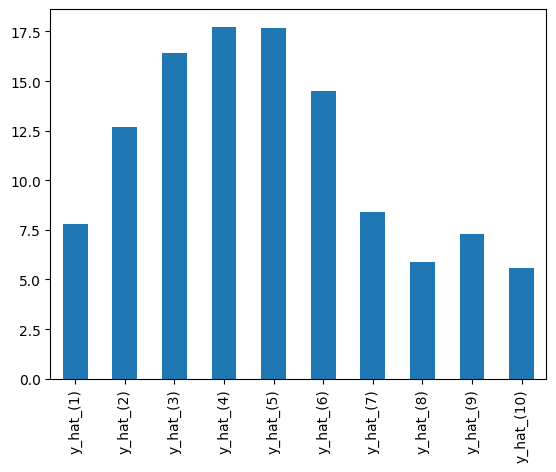

In [73]:
error_df = staircase_df.copy()
for col in [c for c in error_df.columns if c != "x"]:
    error_df[col] = (error_df[col] - staircase_df["y"])**2
res = error_df.sum()
res[[c for c in error_df.columns if "y_hat" in c]].plot.bar()